<a href="https://colab.research.google.com/github/lo-uis/Team_ChoLab/blob/develop/stl_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import google.colab.drive
google.colab.drive.mount("gdrive")

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [0]:
#!pip install pytorch-lightning

In [0]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from PIL import Image
from torchvision import models, transforms
from tqdm import tqdm

# **前処理**

In [0]:
# tranform tensor
#前処理できる
#trainデータセットの前処理


transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224), #サイズ合わせ
    #transforms.RandomHorizontalFlip(), #
    transforms.ToTensor() ,              #型変換(?)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  #多分正規化
    
    ])

In [0]:
#validationデータセットの前処理
transform_val = transforms.Compose([
    transforms.RandomResizedCrop(224), #サイズ合わせ
    transforms.ToTensor() ,              #型変換(?)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  #多分正規化
    ])

In [0]:
#load train
#学習に用いて良い画像は、STL10のtrain,unlabeled画像のみとする。
#STL10のテスト画像は、上記の運営賞に用いるので、validationとして用いること
train = torchvision.datasets.STL10(
    root=".", 
    split='train', 
    folds=None,                          #０〜９で選べるぽい
    transform=transform_train,                     #読み込み時の処理
    target_transform=None, 
    download=False)

In [9]:
#データセットの中身を確認
train

Dataset STL10
    Number of datapoints: 5000
    Root location: .
    Split: train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [0]:
#load test for validation
val = torchvision.datasets.STL10(
    root=".", 
    split="test", 
    folds=None,                          
    transform=transform_val,                     
    target_transform=None, 
    download=False)

In [11]:
val

Dataset STL10
    Number of datapoints: 8000
    Root location: .
    Split: test
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [0]:
#train[0][0].shape

In [12]:
#可視化してみる
import numpy as np
import matplotlib.pyplot as plt
img = np.transpose(train[1][0],(1,2,0))
img.shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


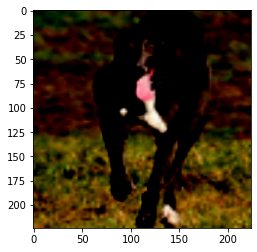

In [13]:
plt.imshow(img)

In [0]:
#type(train[0])

In [0]:
#train[0][0]

In [0]:
#train[1][1]

In [0]:
batch_size = 64

training_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False) # testはvaldationとして扱う

#dataloaders_dict = {"train": train_dataloader, "val": val_dataloader} # 辞書オブジェクトにまとめる

# **ただ単にVGG16にぶっこんだ**

In [0]:
#とりあえずVGG16に突っ込んでみる
class VGG16(nn.Module):
  def __init__(self):
    super(VGG16,self).__init__()
    self.features = nn.Sequential(
                      nn.Conv2d(3, 64, kernel_size=3,stride=1,padding=1),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(64, 64, kernel_size=3,stride=1,padding=1),
                      nn.ReLU(inplace=True),
                      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                      nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                      nn.ReLU(inplace=True),
                      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                      nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                      nn.ReLU(inplace=True),
                      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                      nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                      nn.ReLU(inplace=True),
                      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                      nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                      nn.ReLU(inplace=True),
                      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                    )
    
    self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))
    
    self.classifier = nn.Sequential(
                      nn.Linear(in_features=25088, out_features=4096, bias=True),
                      nn.ReLU(inplace=True),
                      nn.Dropout(p=0.5, inplace=False),
                      nn.Linear(in_features=4096, out_features=4096, bias=True),
                      nn.ReLU(inplace=True),
                      nn.Dropout(p=0.5, inplace=False),
                      nn.Linear(in_features=4096, out_features=1000, bias=True),
    )

  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)

    return x

In [0]:
#GPU使う
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
#vgg16_ver1 = VGG16()
#print(vgg16_ver1)
model = VGG16().to(device)

In [0]:
##パラメーターの設定
model.classifier[6] = nn.Linear(in_features=4096, out_features=10).cuda() # クラス数を10にする
criterion = nn.CrossEntropyLoss() #  損失関数の設定
#optimizer = optim.Adam(model.parameters(),lr=0.001)  # 最適化関数の設定
optimizer = optim.SGD(model.parameters(),lr=0.001, momentum=0.9)  # 最適化関数の設定

In [0]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [0]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  model.train() #学習モード
  
  for inputs, labels in training_loader:
#     DataLoaderのバッチサイズごとにforで取り出して計算
#     ここのforの処理が終わると1エポック
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
#     一旦パラメーターの勾配をゼロにして
    optimizer.zero_grad()
#     勾配の計算
    loss.backward()
#     学習
    optimizer.step()
    
#     分類わけなので、もっとも数字が大きいものをpredictとする
#     バッチ処理しているので2次元目で比較
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
#     ラベルと合っているものを足し合わせてaccuracy計算
    running_corrects += torch.sum(preds == labels.data)
  
  model.eval() #検証モード
#     pytorchでは勾配の計算の高速化のため、パラメーターを保持しているがテスト時はいらないので止める
  with torch.no_grad():
    for val_inputs, val_labels in validation_loader:
      val_inputs = val_inputs.to(device)
      val_labels = val_labels.to(device)
      val_outputs = model(val_inputs)
      val_loss = criterion(val_outputs, val_labels)
      
      _, val_preds = torch.max(val_outputs, 1)
      val_running_loss += val_loss.item()
      val_running_corrects += torch.sum(val_preds == val_labels.data)
      
#   学習過程を記録
  epoch_loss = running_loss/len(training_loader.dataset)
  epoch_acc = running_corrects.float()/ len(training_loader.dataset)
  running_loss_history.append(epoch_loss)
  running_corrects_history.append(epoch_acc)
  
  val_epoch_loss = val_running_loss/len(validation_loader.dataset)
#     print('len-validation_loader :'+str(len(validation_loader)))
#     print('len-validation_loader :'+str(len(validation_loader.dataset)))
  val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset)
  val_running_loss_history.append(val_epoch_loss)
  val_running_corrects_history.append(val_epoch_acc)
  
  print('epoch *', (e+1))
  print('training loss: {:.4f}, training acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
  print('validation loss: {:.4f}, validation acc{:.4f}'.format(val_epoch_loss,val_epoch_acc.item()))

epoch * 1
training loss: 0.2879, training acc 0.0948
validation loss: 0.2878, validation acc0.1000
epoch * 2
training loss: 0.2879, training acc 0.0952
validation loss: 0.2878, validation acc0.1000
epoch * 3
training loss: 0.2879, training acc 0.0916
validation loss: 0.2878, validation acc0.1000
epoch * 4
training loss: 0.2879, training acc 0.0888
validation loss: 0.2878, validation acc0.1000
epoch * 5
training loss: 0.2879, training acc 0.0838
validation loss: 0.2878, validation acc0.1000
epoch * 6
training loss: 0.2879, training acc 0.0990
validation loss: 0.2878, validation acc0.1000
epoch * 7
training loss: 0.2879, training acc 0.0974
validation loss: 0.2878, validation acc0.1000
epoch * 8
training loss: 0.2879, training acc 0.0888
validation loss: 0.2878, validation acc0.1000


KeyboardInterrupt: ignored

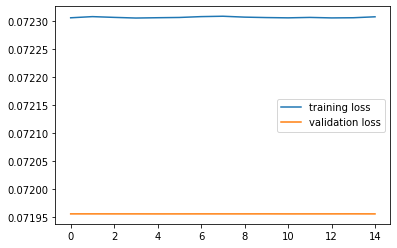

In [0]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

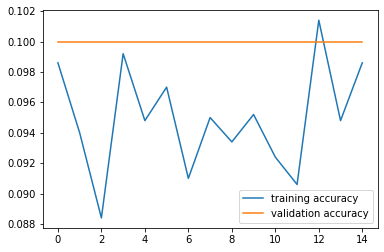

In [0]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

# **VGG16転移学習**
参考：https://github.com/YutaroOgawa/pytorch_advanced.git


In [35]:
# 学習済みのVGG-16モデルをロード
# VGG-16モデルのインスタンスを生成
#GPU使う
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_pretrained = True  # 学習済みのパラメータを使用
model = models.vgg16(pretrained=use_pretrained).to(device)


model.classifier[6] = nn.Linear(in_features=4096, out_features=10).to(device)
print(models.vgg16())

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

In [19]:
# 転移学習で学習させるパラメータを、変数params_to_updateに格納する
params_to_update = []

# 学習させるパラメータ名
update_param_names = ["classifier.6.weight", "classifier.6.bias"]

# 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
for name, param in model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

# params_to_updateの中身を確認
print("-----------")
print(params_to_update)

classifier.6.weight
classifier.6.bias
-----------
[Parameter containing:
tensor([[-0.0014, -0.0081,  0.0098,  ...,  0.0129,  0.0145, -0.0141],
        [-0.0028,  0.0140, -0.0086,  ..., -0.0146, -0.0046,  0.0091],
        [ 0.0140, -0.0031,  0.0012,  ..., -0.0070,  0.0045,  0.0063],
        ...,
        [ 0.0112, -0.0013, -0.0017,  ...,  0.0053,  0.0151,  0.0154],
        [-0.0039, -0.0013, -0.0004,  ..., -0.0102, -0.0012, -0.0020],
        [-0.0096, -0.0073, -0.0127,  ...,  0.0061, -0.0066, -0.0063]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([-0.0090, -0.0148,  0.0003, -0.0005, -0.0026,  0.0070,  0.0129, -0.0063,
         0.0155,  0.0136], device='cuda:0', requires_grad=True)]


In [0]:
# 最適化手法の設定
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)


In [0]:
#EarlyStopipingを導入するために、pytorchtools.pyをアップする
from pytorchtools import EarlyStopping

In [23]:
epochs = 150
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
early_stopping = EarlyStopping(patience=20, verbose=True)  # early stopping patience; how long to wait after last time validation loss improved.

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  model.train() #学習モード
  
  for inputs, labels in tqdm(training_loader):
#     DataLoaderのバッチサイズごとにforで取り出して計算
#     ここのforの処理が終わると1エポック
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
#     一旦パラメーターの勾配をゼロにして
    optimizer.zero_grad()
#     勾配の計算
    loss.backward()
#     学習
    optimizer.step()
    
#     分類わけなので、もっとも数字が大きいものをpredictとする
#     バッチ処理しているので2次元目で比較
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
#     ラベルと合っているものを足し合わせてaccuracy計算
    running_corrects += torch.sum(preds == labels.data)
  
  model.eval() #検証モード
#     pytorchでは勾配の計算の高速化のため、パラメーターを保持しているがテスト時はいらないので止める
  with torch.no_grad():
    for val_inputs, val_labels in tqdm(validation_loader):
      val_inputs = val_inputs.to(device)
      val_labels = val_labels.to(device)
      val_outputs = model(val_inputs)
      val_loss = criterion(val_outputs, val_labels)
      
      _, val_preds = torch.max(val_outputs, 1)
      val_running_loss += val_loss.item()
      val_running_corrects += torch.sum(val_preds == val_labels.data)
      
#   学習過程を記録
  epoch_loss = running_loss/len(training_loader.dataset)
  epoch_acc = running_corrects.float()/ len(training_loader.dataset)
  running_loss_history.append(epoch_loss)
  running_corrects_history.append(epoch_acc)
  
  val_epoch_loss = val_running_loss/len(validation_loader.dataset)
#     print('len-validation_loader :'+str(len(validation_loader)))
#     print('len-validation_loader :'+str(len(validation_loader.dataset)))
  val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset)
  val_running_loss_history.append(val_epoch_loss)
  val_running_corrects_history.append(val_epoch_acc)
  
  print('epoch *', (e+1))
  print('training loss: {:.4f}, training acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
  print('validation loss: {:.4f}, validation acc{:.4f}'.format(val_epoch_loss,val_epoch_acc.item()))

  early_stopping(val_epoch_loss, model)
        
  if early_stopping.early_stop:
      print("Early stopping")
      break
#学習済みモデルの保存
save_path = './weights.pth'
torch.save(model.state_dict(), save_path)


 15%|█▌        | 12/79 [00:05<00:28,  2.35it/s]

KeyboardInterrupt: ignored

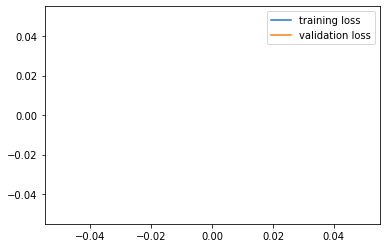

In [24]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

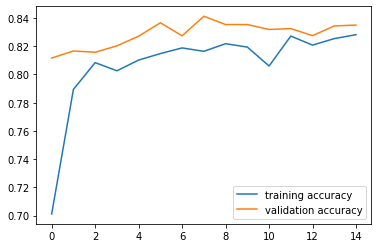

In [0]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [0]:
#学習済みモデルの保存
save_path = './weights.pth'
torch.save(model.state_dict(), save_path)

# **VGG16ファインチューニング**
参考：https://github.com/YutaroOgawa/pytorch_advanced

In [0]:
# 学習済みのVGG-16モデルをロード
# VGG-16モデルのインスタンスを生成
#GPU使う
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_pretrained = True  # 学習済みのパラメータを使用
model = models.vgg16(pretrained=use_pretrained).to(device)


model.classifier[6] = nn.Linear(in_features=4096, out_features=10).to(device)

In [0]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

In [28]:
# ファインチューニングで学習させるパラメータを、変数params_to_updateの1～3に格納する

params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# 学習させる層のパラメータ名を指定
update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight",
                        "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

# パラメータごとに各リストに格納する
for name, param in model.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1に格納：", name)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2に格納：", name)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3に格納：", name)

    else:
        param.requires_grad = False
        print("勾配計算なし。学習しない：", name)

params_to_update_1に格納： features.0.weight
params_to_update_1に格納： features.0.bias
params_to_update_1に格納： features.2.weight
params_to_update_1に格納： features.2.bias
params_to_update_1に格納： features.5.weight
params_to_update_1に格納： features.5.bias
params_to_update_1に格納： features.7.weight
params_to_update_1に格納： features.7.bias
params_to_update_1に格納： features.10.weight
params_to_update_1に格納： features.10.bias
params_to_update_1に格納： features.12.weight
params_to_update_1に格納： features.12.bias
params_to_update_1に格納： features.14.weight
params_to_update_1に格納： features.14.bias
params_to_update_1に格納： features.17.weight
params_to_update_1に格納： features.17.bias
params_to_update_1に格納： features.19.weight
params_to_update_1に格納： features.19.bias
params_to_update_1に格納： features.21.weight
params_to_update_1に格納： features.21.bias
params_to_update_1に格納： features.24.weight
params_to_update_1に格納： features.24.bias
params_to_update_1に格納： features.26.weight
params_to_update_1に格納： features.26.bias
params_to_update_1に格納： f

In [0]:
# 最適化手法の設定
optimizer = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 5e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
], momentum=0.9)

In [32]:
epochs = 60
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
early_stopping = EarlyStopping(patience=3, verbose=True)  # early stopping patience; how long to wait after last time validation loss improved.

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  model.train() #学習モード
  
  for inputs, labels in tqdm(training_loader):
#     DataLoaderのバッチサイズごとにforで取り出して計算
#     ここのforの処理が終わると1エポック
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
#     一旦パラメーターの勾配をゼロにして
    optimizer.zero_grad()
#     勾配の計算
    loss.backward()
#     学習
    optimizer.step()
    
#     分類わけなので、もっとも数字が大きいものをpredictとする
#     バッチ処理しているので2次元目で比較
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
#     ラベルと合っているものを足し合わせてaccuracy計算
    running_corrects += torch.sum(preds == labels.data)
  
  model.eval() #検証モード
#     pytorchでは勾配の計算の高速化のため、パラメーターを保持しているがテスト時はいらないので止める
  with torch.no_grad():
    for val_inputs, val_labels in tqdm(validation_loader):
      val_inputs = val_inputs.to(device)
      val_labels = val_labels.to(device)
      val_outputs = model(val_inputs)
      val_loss = criterion(val_outputs, val_labels)
      
      _, val_preds = torch.max(val_outputs, 1)
      val_running_loss += val_loss.item()
      val_running_corrects += torch.sum(val_preds == val_labels.data)
      
#   学習過程を記録
  epoch_loss = running_loss/len(training_loader.dataset)
  epoch_acc = running_corrects.float()/ len(training_loader.dataset)
  running_loss_history.append(epoch_loss)
  running_corrects_history.append(epoch_acc)
  
  val_epoch_loss = val_running_loss/len(validation_loader.dataset)
#     print('len-validation_loader :'+str(len(validation_loader)))
#     print('len-validation_loader :'+str(len(validation_loader.dataset)))
  val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset)
  val_running_loss_history.append(val_epoch_loss)
  val_running_corrects_history.append(val_epoch_acc)
  
  print('epoch *', (e+1))
  print('training loss: {:.4f}, training acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
  print('validation loss: {:.4f}, validation acc{:.4f}'.format(val_epoch_loss,val_epoch_acc.item()))

  early_stopping(val_epoch_loss, model)
        
  if early_stopping.early_stop:
      print("Early stopping")
      break
#学習済みモデルの保存
save_path = './weights.pth'
torch.save(model.state_dict(), save_path)



  0%|          | 0/79 [00:00<?, ?it/s]

  1%|▏         | 1/79 [00:01<01:28,  1.13s/it]

  3%|▎         | 2/79 [00:02<01:27,  1.13s/it]

  4%|▍         | 3/79 [00:03<01:26,  1.14s/it]

  5%|▌         | 4/79 [00:04<01:25,  1.14s/it]

  6%|▋         | 5/79 [00:05<01:24,  1.15s/it]

  8%|▊         | 6/79 [00:06<01:23,  1.15s/it]

  9%|▉         | 7/79 [00:08<01:22,  1.15s/it]

 10%|█         | 8/79 [00:09<01:22,  1.16s/it]

 11%|█▏        | 9/79 [00:10<01:21,  1.16s/it]

 13%|█▎        | 10/79 [00:11<01:20,  1.16s/it]

 14%|█▍        | 11/79 [00:12<01:18,  1.16s/it]

 15%|█▌        | 12/79 [00:13<01:18,  1.17s/it]

 16%|█▋        | 13/79 [00:15<01:17,  1.17s/it]

 18%|█▊        | 14/79 [00:16<01:16,  1.17s/it]

 19%|█▉        | 15/79 [00:17<01:15,  1.17s/it]

 20%|██        | 16/79 [00:18<01:13,  1.17s/it]

 22%|██▏       | 17/79 [00:19<01:13,  1.18s/it]

 23%|██▎       | 18/79 [00:20<01:11,  1.18s/it]

 24%|██▍       | 19/79 [00:22<01:11,  1.19s/it]

 25%|██▌       | 20/79 [00:23<01:09,

epoch * 1
training loss: 0.0174, training acc 0.6372
validation loss: 0.0079, validation acc0.8318
Validation loss decreased (inf --> 0.007881).  Saving model ...




  0%|          | 0/79 [00:00<?, ?it/s]

  1%|▏         | 1/79 [00:01<01:29,  1.14s/it]

  3%|▎         | 2/79 [00:02<01:28,  1.15s/it]

  4%|▍         | 3/79 [00:03<01:27,  1.15s/it]

  5%|▌         | 4/79 [00:04<01:25,  1.15s/it]

  6%|▋         | 5/79 [00:05<01:24,  1.15s/it]

  8%|▊         | 6/79 [00:06<01:23,  1.14s/it]

  9%|▉         | 7/79 [00:08<01:22,  1.14s/it]

 10%|█         | 8/79 [00:09<01:21,  1.15s/it]

 11%|█▏        | 9/79 [00:10<01:20,  1.15s/it]

 13%|█▎        | 10/79 [00:11<01:19,  1.15s/it]

 14%|█▍        | 11/79 [00:12<01:17,  1.14s/it]

 15%|█▌        | 12/79 [00:13<01:16,  1.15s/it]

 16%|█▋        | 13/79 [00:14<01:15,  1.15s/it]

 18%|█▊        | 14/79 [00:16<01:14,  1.14s/it]

 19%|█▉        | 15/79 [00:17<01:13,  1.14s/it]

 20%|██        | 16/79 [00:18<01:12,  1.15s/it]

 22%|██▏       | 17/79 [00:19<01:11,  1.15s/it]

 23%|██▎       | 18/79 [00:20<01:10,  1.15s/it]

 24%|██▍       | 19/79 [00:21<01:08,  1.15s/it]

 25%|██▌       | 20/79 [00:22<01:07,

epoch * 2
training loss: 0.0081, training acc 0.8204
validation loss: 0.0066, validation acc0.8540
Validation loss decreased (0.007881 --> 0.006562).  Saving model ...




  0%|          | 0/79 [00:00<?, ?it/s]

  1%|▏         | 1/79 [00:01<01:32,  1.19s/it]

  3%|▎         | 2/79 [00:02<01:30,  1.18s/it]

  4%|▍         | 3/79 [00:03<01:29,  1.17s/it]

  5%|▌         | 4/79 [00:04<01:27,  1.17s/it]

  6%|▋         | 5/79 [00:05<01:26,  1.16s/it]

  8%|▊         | 6/79 [00:06<01:24,  1.16s/it]

  9%|▉         | 7/79 [00:08<01:23,  1.16s/it]

 10%|█         | 8/79 [00:09<01:21,  1.15s/it]

 11%|█▏        | 9/79 [00:10<01:20,  1.15s/it]

 13%|█▎        | 10/79 [00:11<01:19,  1.15s/it]

 14%|█▍        | 11/79 [00:12<01:18,  1.15s/it]

 15%|█▌        | 12/79 [00:13<01:17,  1.15s/it]

 16%|█▋        | 13/79 [00:15<01:16,  1.15s/it]

 18%|█▊        | 14/79 [00:16<01:15,  1.15s/it]

 19%|█▉        | 15/79 [00:17<01:13,  1.15s/it]

 20%|██        | 16/79 [00:18<01:12,  1.16s/it]

 22%|██▏       | 17/79 [00:19<01:11,  1.15s/it]

 23%|██▎       | 18/79 [00:20<01:10,  1.15s/it]

 24%|██▍       | 19/79 [00:21<01:08,  1.15s/it]

 25%|██▌       | 20/79 [00:23<01:08,

epoch * 3
training loss: 0.0070, training acc 0.8460
validation loss: 0.0060, validation acc0.8688
Validation loss decreased (0.006562 --> 0.005987).  Saving model ...




  0%|          | 0/79 [00:00<?, ?it/s]

  1%|▏         | 1/79 [00:01<01:33,  1.20s/it]

  3%|▎         | 2/79 [00:02<01:31,  1.19s/it]

  4%|▍         | 3/79 [00:03<01:29,  1.17s/it]

  5%|▌         | 4/79 [00:04<01:27,  1.17s/it]

  6%|▋         | 5/79 [00:05<01:26,  1.17s/it]

  8%|▊         | 6/79 [00:06<01:24,  1.16s/it]

  9%|▉         | 7/79 [00:08<01:23,  1.15s/it]

 10%|█         | 8/79 [00:09<01:21,  1.15s/it]

 11%|█▏        | 9/79 [00:10<01:20,  1.16s/it]

 13%|█▎        | 10/79 [00:11<01:19,  1.15s/it]

 14%|█▍        | 11/79 [00:12<01:17,  1.14s/it]

 15%|█▌        | 12/79 [00:13<01:17,  1.15s/it]

 16%|█▋        | 13/79 [00:14<01:15,  1.15s/it]

 18%|█▊        | 14/79 [00:16<01:14,  1.15s/it]

 19%|█▉        | 15/79 [00:17<01:13,  1.15s/it]

 20%|██        | 16/79 [00:18<01:12,  1.15s/it]

 22%|██▏       | 17/79 [00:19<01:11,  1.15s/it]

 23%|██▎       | 18/79 [00:20<01:10,  1.15s/it]

 24%|██▍       | 19/79 [00:21<01:08,  1.15s/it]

 25%|██▌       | 20/79 [00:23<01:07,

epoch * 4
training loss: 0.0066, training acc 0.8566
validation loss: 0.0059, validation acc0.8676
Validation loss decreased (0.005987 --> 0.005871).  Saving model ...




  0%|          | 0/79 [00:00<?, ?it/s]

  1%|▏         | 1/79 [00:01<01:30,  1.17s/it]

  3%|▎         | 2/79 [00:02<01:29,  1.16s/it]

  4%|▍         | 3/79 [00:03<01:27,  1.15s/it]

  5%|▌         | 4/79 [00:04<01:26,  1.15s/it]

  6%|▋         | 5/79 [00:05<01:25,  1.15s/it]

  8%|▊         | 6/79 [00:06<01:23,  1.15s/it]

  9%|▉         | 7/79 [00:08<01:22,  1.15s/it]

 10%|█         | 8/79 [00:09<01:21,  1.15s/it]

 11%|█▏        | 9/79 [00:10<01:20,  1.14s/it]

 13%|█▎        | 10/79 [00:11<01:19,  1.15s/it]

 14%|█▍        | 11/79 [00:12<01:18,  1.15s/it]

 15%|█▌        | 12/79 [00:13<01:16,  1.14s/it]

 16%|█▋        | 13/79 [00:14<01:15,  1.15s/it]

 18%|█▊        | 14/79 [00:16<01:14,  1.15s/it]

 19%|█▉        | 15/79 [00:17<01:13,  1.15s/it]

 20%|██        | 16/79 [00:18<01:12,  1.15s/it]

 22%|██▏       | 17/79 [00:19<01:11,  1.15s/it]

 23%|██▎       | 18/79 [00:20<01:10,  1.15s/it]

 24%|██▍       | 19/79 [00:21<01:09,  1.16s/it]

 25%|██▌       | 20/79 [00:23<01:08,

epoch * 5
training loss: 0.0063, training acc 0.8578
validation loss: 0.0059, validation acc0.8673
Validation loss decreased (0.005871 --> 0.005855).  Saving model ...




  0%|          | 0/79 [00:00<?, ?it/s]

  1%|▏         | 1/79 [00:01<01:32,  1.19s/it]

  3%|▎         | 2/79 [00:02<01:30,  1.18s/it]

  4%|▍         | 3/79 [00:03<01:28,  1.17s/it]

  5%|▌         | 4/79 [00:04<01:27,  1.17s/it]

  6%|▋         | 5/79 [00:05<01:25,  1.15s/it]

  8%|▊         | 6/79 [00:06<01:24,  1.15s/it]

  9%|▉         | 7/79 [00:08<01:22,  1.15s/it]

 10%|█         | 8/79 [00:09<01:21,  1.15s/it]

 11%|█▏        | 9/79 [00:10<01:20,  1.15s/it]

 13%|█▎        | 10/79 [00:11<01:18,  1.14s/it]

 14%|█▍        | 11/79 [00:12<01:18,  1.15s/it]

 15%|█▌        | 12/79 [00:13<01:17,  1.15s/it]

 16%|█▋        | 13/79 [00:14<01:15,  1.15s/it]

 18%|█▊        | 14/79 [00:16<01:14,  1.15s/it]

 19%|█▉        | 15/79 [00:17<01:13,  1.15s/it]

 20%|██        | 16/79 [00:18<01:12,  1.15s/it]

 22%|██▏       | 17/79 [00:19<01:11,  1.15s/it]

 23%|██▎       | 18/79 [00:20<01:10,  1.15s/it]

 24%|██▍       | 19/79 [00:21<01:08,  1.14s/it]

 25%|██▌       | 20/79 [00:22<01:07,

epoch * 6
training loss: 0.0059, training acc 0.8724
validation loss: 0.0056, validation acc0.8695
Validation loss decreased (0.005855 --> 0.005633).  Saving model ...




  0%|          | 0/79 [00:00<?, ?it/s]

  1%|▏         | 1/79 [00:01<01:30,  1.16s/it]

  3%|▎         | 2/79 [00:02<01:29,  1.16s/it]

  4%|▍         | 3/79 [00:03<01:27,  1.16s/it]

  5%|▌         | 4/79 [00:04<01:25,  1.15s/it]

  6%|▋         | 5/79 [00:05<01:24,  1.15s/it]

  8%|▊         | 6/79 [00:06<01:23,  1.15s/it]

  9%|▉         | 7/79 [00:08<01:22,  1.15s/it]

 10%|█         | 8/79 [00:09<01:21,  1.15s/it]

 11%|█▏        | 9/79 [00:10<01:20,  1.15s/it]

 13%|█▎        | 10/79 [00:11<01:19,  1.15s/it]

 14%|█▍        | 11/79 [00:12<01:18,  1.15s/it]

 15%|█▌        | 12/79 [00:13<01:17,  1.15s/it]

 16%|█▋        | 13/79 [00:14<01:15,  1.15s/it]

 18%|█▊        | 14/79 [00:16<01:15,  1.16s/it]

 19%|█▉        | 15/79 [00:17<01:13,  1.15s/it]

 20%|██        | 16/79 [00:18<01:12,  1.15s/it]

 22%|██▏       | 17/79 [00:19<01:11,  1.16s/it]

 23%|██▎       | 18/79 [00:20<01:10,  1.15s/it]

 24%|██▍       | 19/79 [00:21<01:09,  1.15s/it]

 25%|██▌       | 20/79 [00:23<01:07,

epoch * 7
training loss: 0.0058, training acc 0.8704
validation loss: 0.0055, validation acc0.8741
Validation loss decreased (0.005633 --> 0.005513).  Saving model ...




  0%|          | 0/79 [00:00<?, ?it/s]

  1%|▏         | 1/79 [00:01<01:31,  1.17s/it]

  3%|▎         | 2/79 [00:02<01:29,  1.17s/it]

  4%|▍         | 3/79 [00:03<01:28,  1.16s/it]

  5%|▌         | 4/79 [00:04<01:26,  1.16s/it]

  6%|▋         | 5/79 [00:05<01:25,  1.16s/it]

  8%|▊         | 6/79 [00:06<01:24,  1.15s/it]

  9%|▉         | 7/79 [00:08<01:22,  1.15s/it]

 10%|█         | 8/79 [00:09<01:21,  1.15s/it]

 11%|█▏        | 9/79 [00:10<01:20,  1.15s/it]

 13%|█▎        | 10/79 [00:11<01:19,  1.15s/it]

 14%|█▍        | 11/79 [00:12<01:17,  1.14s/it]

 15%|█▌        | 12/79 [00:13<01:16,  1.15s/it]

 16%|█▋        | 13/79 [00:14<01:15,  1.15s/it]

 18%|█▊        | 14/79 [00:16<01:14,  1.14s/it]

 19%|█▉        | 15/79 [00:17<01:13,  1.15s/it]

 20%|██        | 16/79 [00:18<01:12,  1.15s/it]

 22%|██▏       | 17/79 [00:19<01:10,  1.14s/it]

 23%|██▎       | 18/79 [00:20<01:10,  1.15s/it]

 24%|██▍       | 19/79 [00:21<01:08,  1.15s/it]

 25%|██▌       | 20/79 [00:22<01:07,

epoch * 8
training loss: 0.0055, training acc 0.8806
validation loss: 0.0056, validation acc0.8731
EarlyStopping counter: 1 out of 3




  1%|▏         | 1/79 [00:01<01:30,  1.16s/it]

  3%|▎         | 2/79 [00:02<01:28,  1.15s/it]

  4%|▍         | 3/79 [00:03<01:26,  1.14s/it]

  5%|▌         | 4/79 [00:04<01:25,  1.15s/it]

  6%|▋         | 5/79 [00:05<01:24,  1.15s/it]

  8%|▊         | 6/79 [00:06<01:23,  1.15s/it]

  9%|▉         | 7/79 [00:08<01:22,  1.15s/it]

 10%|█         | 8/79 [00:09<01:21,  1.15s/it]

 11%|█▏        | 9/79 [00:10<01:20,  1.14s/it]

 13%|█▎        | 10/79 [00:11<01:19,  1.15s/it]

 14%|█▍        | 11/79 [00:12<01:17,  1.14s/it]

 15%|█▌        | 12/79 [00:13<01:17,  1.15s/it]

 16%|█▋        | 13/79 [00:14<01:15,  1.15s/it]

 18%|█▊        | 14/79 [00:16<01:14,  1.15s/it]

 19%|█▉        | 15/79 [00:17<01:13,  1.15s/it]

 20%|██        | 16/79 [00:18<01:12,  1.14s/it]

 22%|██▏       | 17/79 [00:19<01:11,  1.15s/it]

 23%|██▎       | 18/79 [00:20<01:09,  1.14s/it]

 24%|██▍       | 19/79 [00:21<01:08,  1.15s/it]

 25%|██▌       | 20/79 [00:22<01:07,  1.15s/it]

 27%|██▋       | 21/79 [00:

epoch * 9
training loss: 0.0057, training acc 0.8704
validation loss: 0.0055, validation acc0.8723
Validation loss decreased (0.005513 --> 0.005461).  Saving model ...




  0%|          | 0/79 [00:00<?, ?it/s]

  1%|▏         | 1/79 [00:01<01:32,  1.18s/it]

  3%|▎         | 2/79 [00:02<01:30,  1.17s/it]

  4%|▍         | 3/79 [00:03<01:28,  1.16s/it]

  5%|▌         | 4/79 [00:04<01:26,  1.15s/it]

  6%|▋         | 5/79 [00:05<01:25,  1.16s/it]

  8%|▊         | 6/79 [00:06<01:24,  1.15s/it]

  9%|▉         | 7/79 [00:08<01:22,  1.15s/it]

 10%|█         | 8/79 [00:09<01:21,  1.15s/it]

 11%|█▏        | 9/79 [00:10<01:20,  1.15s/it]

 13%|█▎        | 10/79 [00:11<01:19,  1.15s/it]

 14%|█▍        | 11/79 [00:12<01:18,  1.15s/it]

 15%|█▌        | 12/79 [00:13<01:17,  1.15s/it]

 16%|█▋        | 13/79 [00:14<01:15,  1.15s/it]

 18%|█▊        | 14/79 [00:16<01:14,  1.15s/it]

 19%|█▉        | 15/79 [00:17<01:13,  1.15s/it]

 20%|██        | 16/79 [00:18<01:12,  1.15s/it]

 22%|██▏       | 17/79 [00:19<01:11,  1.15s/it]

 23%|██▎       | 18/79 [00:20<01:10,  1.15s/it]

 24%|██▍       | 19/79 [00:21<01:08,  1.15s/it]

 25%|██▌       | 20/79 [00:23<01:07,

epoch * 10
training loss: 0.0054, training acc 0.8764
validation loss: 0.0052, validation acc0.8826
Validation loss decreased (0.005461 --> 0.005203).  Saving model ...




  0%|          | 0/79 [00:00<?, ?it/s]

  1%|▏         | 1/79 [00:01<01:32,  1.18s/it]

  3%|▎         | 2/79 [00:02<01:30,  1.18s/it]

  4%|▍         | 3/79 [00:03<01:28,  1.17s/it]

  5%|▌         | 4/79 [00:04<01:27,  1.17s/it]

  6%|▋         | 5/79 [00:05<01:25,  1.16s/it]

  8%|▊         | 6/79 [00:06<01:24,  1.16s/it]

  9%|▉         | 7/79 [00:08<01:23,  1.16s/it]

 10%|█         | 8/79 [00:09<01:22,  1.16s/it]

 11%|█▏        | 9/79 [00:10<01:20,  1.15s/it]

 13%|█▎        | 10/79 [00:11<01:19,  1.15s/it]

 14%|█▍        | 11/79 [00:12<01:18,  1.15s/it]

 15%|█▌        | 12/79 [00:13<01:17,  1.15s/it]

 16%|█▋        | 13/79 [00:15<01:15,  1.15s/it]

 18%|█▊        | 14/79 [00:16<01:15,  1.16s/it]

 19%|█▉        | 15/79 [00:17<01:13,  1.15s/it]

 20%|██        | 16/79 [00:18<01:12,  1.15s/it]

 22%|██▏       | 17/79 [00:19<01:11,  1.16s/it]

 23%|██▎       | 18/79 [00:20<01:10,  1.15s/it]

 24%|██▍       | 19/79 [00:21<01:09,  1.15s/it]

 25%|██▌       | 20/79 [00:23<01:08,

epoch * 11
training loss: 0.0050, training acc 0.8848
validation loss: 0.0052, validation acc0.8820
EarlyStopping counter: 1 out of 3




  1%|▏         | 1/79 [00:01<01:29,  1.15s/it]

  3%|▎         | 2/79 [00:02<01:28,  1.15s/it]

  4%|▍         | 3/79 [00:03<01:27,  1.15s/it]

  5%|▌         | 4/79 [00:04<01:26,  1.15s/it]

  6%|▋         | 5/79 [00:05<01:24,  1.14s/it]

  8%|▊         | 6/79 [00:06<01:23,  1.15s/it]

  9%|▉         | 7/79 [00:08<01:22,  1.15s/it]

 10%|█         | 8/79 [00:09<01:21,  1.15s/it]

 11%|█▏        | 9/79 [00:10<01:20,  1.15s/it]

 13%|█▎        | 10/79 [00:11<01:19,  1.15s/it]

 14%|█▍        | 11/79 [00:12<01:17,  1.15s/it]

 15%|█▌        | 12/79 [00:13<01:16,  1.15s/it]

 16%|█▋        | 13/79 [00:14<01:15,  1.15s/it]

 18%|█▊        | 14/79 [00:16<01:14,  1.15s/it]

 19%|█▉        | 15/79 [00:17<01:13,  1.15s/it]

 20%|██        | 16/79 [00:18<01:12,  1.15s/it]

 22%|██▏       | 17/79 [00:19<01:11,  1.15s/it]

 23%|██▎       | 18/79 [00:20<01:10,  1.15s/it]

 24%|██▍       | 19/79 [00:21<01:08,  1.15s/it]

 25%|██▌       | 20/79 [00:22<01:07,  1.15s/it]

 27%|██▋       | 21/79 [00:

epoch * 12
training loss: 0.0049, training acc 0.8896
validation loss: 0.0054, validation acc0.8749
EarlyStopping counter: 2 out of 3




  1%|▏         | 1/79 [00:01<01:30,  1.16s/it]

  3%|▎         | 2/79 [00:02<01:28,  1.15s/it]

  4%|▍         | 3/79 [00:03<01:27,  1.16s/it]

  5%|▌         | 4/79 [00:04<01:26,  1.15s/it]

  6%|▋         | 5/79 [00:05<01:25,  1.15s/it]

  8%|▊         | 6/79 [00:06<01:23,  1.15s/it]

  9%|▉         | 7/79 [00:08<01:22,  1.15s/it]

 10%|█         | 8/79 [00:09<01:21,  1.15s/it]

 11%|█▏        | 9/79 [00:10<01:20,  1.15s/it]

 13%|█▎        | 10/79 [00:11<01:19,  1.15s/it]

 14%|█▍        | 11/79 [00:12<01:18,  1.15s/it]

 15%|█▌        | 12/79 [00:13<01:17,  1.15s/it]

 16%|█▋        | 13/79 [00:14<01:16,  1.15s/it]

 18%|█▊        | 14/79 [00:16<01:14,  1.15s/it]

 19%|█▉        | 15/79 [00:17<01:13,  1.15s/it]

 20%|██        | 16/79 [00:18<01:12,  1.15s/it]

 22%|██▏       | 17/79 [00:19<01:11,  1.15s/it]

 23%|██▎       | 18/79 [00:20<01:10,  1.15s/it]

 24%|██▍       | 19/79 [00:21<01:09,  1.15s/it]

 25%|██▌       | 20/79 [00:23<01:07,  1.15s/it]

 27%|██▋       | 21/79 [00:

epoch * 13
training loss: 0.0051, training acc 0.8890
validation loss: 0.0052, validation acc0.8819
Validation loss decreased (0.005203 --> 0.005158).  Saving model ...




  0%|          | 0/79 [00:00<?, ?it/s]

  1%|▏         | 1/79 [00:01<01:32,  1.18s/it]

  3%|▎         | 2/79 [00:02<01:30,  1.17s/it]

  4%|▍         | 3/79 [00:03<01:28,  1.16s/it]

  5%|▌         | 4/79 [00:04<01:26,  1.16s/it]

  6%|▋         | 5/79 [00:05<01:25,  1.16s/it]

  8%|▊         | 6/79 [00:06<01:24,  1.15s/it]

  9%|▉         | 7/79 [00:08<01:23,  1.15s/it]

 10%|█         | 8/79 [00:09<01:21,  1.15s/it]

 11%|█▏        | 9/79 [00:10<01:20,  1.15s/it]

 13%|█▎        | 10/79 [00:11<01:19,  1.15s/it]

 14%|█▍        | 11/79 [00:12<01:18,  1.16s/it]

 15%|█▌        | 12/79 [00:13<01:17,  1.15s/it]

 16%|█▋        | 13/79 [00:14<01:16,  1.15s/it]

 18%|█▊        | 14/79 [00:16<01:14,  1.15s/it]

 19%|█▉        | 15/79 [00:17<01:13,  1.15s/it]

 20%|██        | 16/79 [00:18<01:12,  1.16s/it]

 22%|██▏       | 17/79 [00:19<01:11,  1.15s/it]

 23%|██▎       | 18/79 [00:20<01:10,  1.15s/it]

 24%|██▍       | 19/79 [00:21<01:09,  1.16s/it]

 25%|██▌       | 20/79 [00:23<01:08,

epoch * 14
training loss: 0.0046, training acc 0.8964
validation loss: 0.0051, validation acc0.8855
Validation loss decreased (0.005158 --> 0.005062).  Saving model ...




  0%|          | 0/79 [00:00<?, ?it/s]

  1%|▏         | 1/79 [00:01<01:30,  1.16s/it]

  3%|▎         | 2/79 [00:02<01:29,  1.16s/it]

  4%|▍         | 3/79 [00:03<01:27,  1.16s/it]

  5%|▌         | 4/79 [00:04<01:26,  1.16s/it]

  6%|▋         | 5/79 [00:05<01:25,  1.16s/it]

  8%|▊         | 6/79 [00:06<01:24,  1.16s/it]

  9%|▉         | 7/79 [00:08<01:23,  1.15s/it]

 10%|█         | 8/79 [00:09<01:22,  1.16s/it]

 11%|█▏        | 9/79 [00:10<01:20,  1.15s/it]

 13%|█▎        | 10/79 [00:11<01:19,  1.15s/it]

 14%|█▍        | 11/79 [00:12<01:18,  1.15s/it]

 15%|█▌        | 12/79 [00:13<01:17,  1.16s/it]

 16%|█▋        | 13/79 [00:15<01:16,  1.15s/it]

 18%|█▊        | 14/79 [00:16<01:14,  1.15s/it]

 19%|█▉        | 15/79 [00:17<01:14,  1.16s/it]

 20%|██        | 16/79 [00:18<01:12,  1.15s/it]

 22%|██▏       | 17/79 [00:19<01:11,  1.15s/it]

 23%|██▎       | 18/79 [00:20<01:10,  1.15s/it]

 24%|██▍       | 19/79 [00:21<01:09,  1.15s/it]

 25%|██▌       | 20/79 [00:23<01:08,

epoch * 15
training loss: 0.0046, training acc 0.8942
validation loss: 0.0050, validation acc0.8866
Validation loss decreased (0.005062 --> 0.004999).  Saving model ...




  0%|          | 0/79 [00:00<?, ?it/s]

  1%|▏         | 1/79 [00:01<01:33,  1.20s/it]

  3%|▎         | 2/79 [00:02<01:31,  1.19s/it]

  4%|▍         | 3/79 [00:03<01:29,  1.17s/it]

  5%|▌         | 4/79 [00:04<01:26,  1.16s/it]

  6%|▋         | 5/79 [00:05<01:25,  1.16s/it]

  8%|▊         | 6/79 [00:06<01:24,  1.16s/it]

  9%|▉         | 7/79 [00:08<01:23,  1.16s/it]

 10%|█         | 8/79 [00:09<01:21,  1.15s/it]

 11%|█▏        | 9/79 [00:10<01:20,  1.15s/it]

 13%|█▎        | 10/79 [00:11<01:19,  1.15s/it]

 14%|█▍        | 11/79 [00:12<01:18,  1.15s/it]

 15%|█▌        | 12/79 [00:13<01:16,  1.15s/it]

 16%|█▋        | 13/79 [00:14<01:15,  1.15s/it]

 18%|█▊        | 14/79 [00:16<01:15,  1.16s/it]

 19%|█▉        | 15/79 [00:17<01:13,  1.15s/it]

 20%|██        | 16/79 [00:18<01:12,  1.15s/it]

 22%|██▏       | 17/79 [00:19<01:11,  1.16s/it]

 23%|██▎       | 18/79 [00:20<01:10,  1.15s/it]

 24%|██▍       | 19/79 [00:21<01:09,  1.15s/it]

 25%|██▌       | 20/79 [00:23<01:07,

epoch * 16
training loss: 0.0045, training acc 0.8960
validation loss: 0.0051, validation acc0.8826
EarlyStopping counter: 1 out of 3




  1%|▏         | 1/79 [00:01<01:30,  1.16s/it]

  3%|▎         | 2/79 [00:02<01:29,  1.16s/it]

  4%|▍         | 3/79 [00:03<01:27,  1.15s/it]

  5%|▌         | 4/79 [00:04<01:26,  1.15s/it]

  6%|▋         | 5/79 [00:05<01:25,  1.15s/it]

  8%|▊         | 6/79 [00:06<01:24,  1.15s/it]

  9%|▉         | 7/79 [00:08<01:22,  1.15s/it]

 10%|█         | 8/79 [00:09<01:21,  1.15s/it]

 11%|█▏        | 9/79 [00:10<01:20,  1.15s/it]

 13%|█▎        | 10/79 [00:11<01:19,  1.15s/it]

 14%|█▍        | 11/79 [00:12<01:18,  1.16s/it]

 15%|█▌        | 12/79 [00:13<01:17,  1.15s/it]

 16%|█▋        | 13/79 [00:14<01:16,  1.15s/it]

 18%|█▊        | 14/79 [00:16<01:14,  1.15s/it]

 19%|█▉        | 15/79 [00:17<01:13,  1.15s/it]

 20%|██        | 16/79 [00:18<01:12,  1.15s/it]

 22%|██▏       | 17/79 [00:19<01:10,  1.14s/it]

 23%|██▎       | 18/79 [00:20<01:09,  1.15s/it]

 24%|██▍       | 19/79 [00:21<01:08,  1.15s/it]

 25%|██▌       | 20/79 [00:23<01:07,  1.15s/it]

 27%|██▋       | 21/79 [00:

epoch * 17
training loss: 0.0046, training acc 0.8988
validation loss: 0.0051, validation acc0.8856
EarlyStopping counter: 2 out of 3




  1%|▏         | 1/79 [00:01<01:30,  1.16s/it]

  3%|▎         | 2/79 [00:02<01:28,  1.15s/it]

  4%|▍         | 3/79 [00:03<01:27,  1.16s/it]

  5%|▌         | 4/79 [00:04<01:26,  1.15s/it]

  6%|▋         | 5/79 [00:05<01:25,  1.15s/it]

  8%|▊         | 6/79 [00:06<01:24,  1.16s/it]

  9%|▉         | 7/79 [00:08<01:23,  1.15s/it]

 10%|█         | 8/79 [00:09<01:22,  1.16s/it]

 11%|█▏        | 9/79 [00:10<01:21,  1.16s/it]

 13%|█▎        | 10/79 [00:11<01:19,  1.15s/it]

 14%|█▍        | 11/79 [00:12<01:18,  1.15s/it]

 15%|█▌        | 12/79 [00:13<01:16,  1.15s/it]

 16%|█▋        | 13/79 [00:14<01:15,  1.15s/it]

 18%|█▊        | 14/79 [00:16<01:14,  1.15s/it]

 19%|█▉        | 15/79 [00:17<01:13,  1.15s/it]

 20%|██        | 16/79 [00:18<01:12,  1.16s/it]

 22%|██▏       | 17/79 [00:19<01:11,  1.15s/it]

 23%|██▎       | 18/79 [00:20<01:10,  1.15s/it]

 24%|██▍       | 19/79 [00:21<01:09,  1.16s/it]

 25%|██▌       | 20/79 [00:23<01:08,  1.15s/it]

 27%|██▋       | 21/79 [00:

epoch * 18
training loss: 0.0047, training acc 0.8934
validation loss: 0.0050, validation acc0.8871
Validation loss decreased (0.004999 --> 0.004964).  Saving model ...




  0%|          | 0/79 [00:00<?, ?it/s]

  1%|▏         | 1/79 [00:01<01:31,  1.17s/it]

  3%|▎         | 2/79 [00:02<01:30,  1.17s/it]

  4%|▍         | 3/79 [00:03<01:28,  1.17s/it]

  5%|▌         | 4/79 [00:04<01:27,  1.16s/it]

  6%|▋         | 5/79 [00:05<01:25,  1.16s/it]

  8%|▊         | 6/79 [00:06<01:24,  1.16s/it]

  9%|▉         | 7/79 [00:08<01:22,  1.15s/it]

 10%|█         | 8/79 [00:09<01:21,  1.15s/it]

 11%|█▏        | 9/79 [00:10<01:20,  1.15s/it]

 13%|█▎        | 10/79 [00:11<01:19,  1.15s/it]

 14%|█▍        | 11/79 [00:12<01:18,  1.16s/it]

 15%|█▌        | 12/79 [00:13<01:17,  1.15s/it]

 16%|█▋        | 13/79 [00:15<01:16,  1.15s/it]

 18%|█▊        | 14/79 [00:16<01:14,  1.15s/it]

 19%|█▉        | 15/79 [00:17<01:13,  1.15s/it]

 20%|██        | 16/79 [00:18<01:12,  1.15s/it]

 22%|██▏       | 17/79 [00:19<01:11,  1.15s/it]

 23%|██▎       | 18/79 [00:20<01:10,  1.15s/it]

 24%|██▍       | 19/79 [00:21<01:09,  1.16s/it]

 25%|██▌       | 20/79 [00:23<01:08,

epoch * 19
training loss: 0.0045, training acc 0.9020
validation loss: 0.0047, validation acc0.8894
Validation loss decreased (0.004964 --> 0.004737).  Saving model ...




  0%|          | 0/79 [00:00<?, ?it/s]

  1%|▏         | 1/79 [00:01<01:30,  1.16s/it]

  3%|▎         | 2/79 [00:02<01:29,  1.16s/it]

  4%|▍         | 3/79 [00:03<01:27,  1.16s/it]

  5%|▌         | 4/79 [00:04<01:26,  1.16s/it]

  6%|▋         | 5/79 [00:05<01:25,  1.16s/it]

  8%|▊         | 6/79 [00:06<01:24,  1.16s/it]

  9%|▉         | 7/79 [00:08<01:23,  1.16s/it]

 10%|█         | 8/79 [00:09<01:22,  1.16s/it]

 11%|█▏        | 9/79 [00:10<01:21,  1.16s/it]

 13%|█▎        | 10/79 [00:11<01:20,  1.16s/it]

 14%|█▍        | 11/79 [00:12<01:18,  1.16s/it]

 15%|█▌        | 12/79 [00:13<01:17,  1.16s/it]

 16%|█▋        | 13/79 [00:15<01:16,  1.16s/it]

 18%|█▊        | 14/79 [00:16<01:15,  1.16s/it]

 19%|█▉        | 15/79 [00:17<01:13,  1.15s/it]

 20%|██        | 16/79 [00:18<01:13,  1.16s/it]

 22%|██▏       | 17/79 [00:19<01:11,  1.16s/it]

 23%|██▎       | 18/79 [00:20<01:10,  1.16s/it]

 24%|██▍       | 19/79 [00:22<01:09,  1.16s/it]

 25%|██▌       | 20/79 [00:23<01:08,

epoch * 20
training loss: 0.0042, training acc 0.9062
validation loss: 0.0050, validation acc0.8834
EarlyStopping counter: 1 out of 3




  1%|▏         | 1/79 [00:01<01:31,  1.17s/it]

  3%|▎         | 2/79 [00:02<01:29,  1.16s/it]

  4%|▍         | 3/79 [00:03<01:28,  1.16s/it]

  5%|▌         | 4/79 [00:04<01:26,  1.16s/it]

  6%|▋         | 5/79 [00:05<01:25,  1.15s/it]

  8%|▊         | 6/79 [00:06<01:24,  1.15s/it]

  9%|▉         | 7/79 [00:08<01:23,  1.16s/it]

 10%|█         | 8/79 [00:09<01:22,  1.16s/it]

 11%|█▏        | 9/79 [00:10<01:21,  1.16s/it]

 13%|█▎        | 10/79 [00:11<01:20,  1.16s/it]

 14%|█▍        | 11/79 [00:12<01:18,  1.16s/it]

 15%|█▌        | 12/79 [00:13<01:17,  1.16s/it]

 16%|█▋        | 13/79 [00:15<01:16,  1.16s/it]

 18%|█▊        | 14/79 [00:16<01:15,  1.16s/it]

 19%|█▉        | 15/79 [00:17<01:14,  1.16s/it]

 20%|██        | 16/79 [00:18<01:12,  1.16s/it]

 22%|██▏       | 17/79 [00:19<01:11,  1.16s/it]

 23%|██▎       | 18/79 [00:20<01:10,  1.16s/it]

 24%|██▍       | 19/79 [00:21<01:09,  1.16s/it]

 25%|██▌       | 20/79 [00:23<01:08,  1.15s/it]

 27%|██▋       | 21/79 [00:

epoch * 21
training loss: 0.0044, training acc 0.9010
validation loss: 0.0052, validation acc0.8823
EarlyStopping counter: 2 out of 3




  1%|▏         | 1/79 [00:01<01:32,  1.18s/it]

  3%|▎         | 2/79 [00:02<01:30,  1.17s/it]

  4%|▍         | 3/79 [00:03<01:28,  1.16s/it]

  5%|▌         | 4/79 [00:04<01:26,  1.16s/it]

  6%|▋         | 5/79 [00:05<01:25,  1.16s/it]

  8%|▊         | 6/79 [00:06<01:24,  1.16s/it]

  9%|▉         | 7/79 [00:08<01:23,  1.16s/it]

 10%|█         | 8/79 [00:09<01:22,  1.16s/it]

 11%|█▏        | 9/79 [00:10<01:21,  1.16s/it]

 13%|█▎        | 10/79 [00:11<01:19,  1.15s/it]

 14%|█▍        | 11/79 [00:12<01:18,  1.15s/it]

 15%|█▌        | 12/79 [00:13<01:17,  1.15s/it]

 16%|█▋        | 13/79 [00:15<01:16,  1.15s/it]

 18%|█▊        | 14/79 [00:16<01:15,  1.15s/it]

 19%|█▉        | 15/79 [00:17<01:13,  1.15s/it]

 20%|██        | 16/79 [00:18<01:12,  1.15s/it]

 22%|██▏       | 17/79 [00:19<01:11,  1.16s/it]

 23%|██▎       | 18/79 [00:20<01:10,  1.15s/it]

 24%|██▍       | 19/79 [00:21<01:09,  1.15s/it]

 25%|██▌       | 20/79 [00:23<01:08,  1.15s/it]

 27%|██▋       | 21/79 [00:

epoch * 22
training loss: 0.0043, training acc 0.9042
validation loss: 0.0049, validation acc0.8931
EarlyStopping counter: 3 out of 3
Early stopping


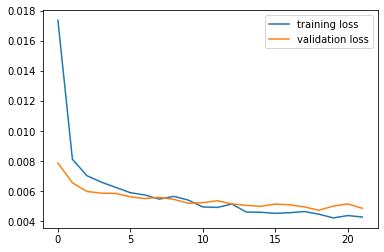

In [33]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

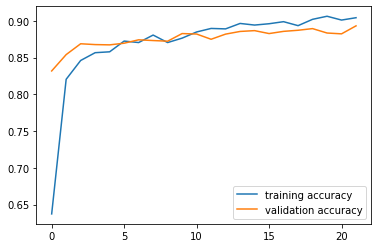

In [34]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

[tensor(0.6372, device='cuda:0'), tensor(0.8204, device='cuda:0'), tensor(0.8460, device='cuda:0'), tensor(0.8566, device='cuda:0'), tensor(0.8578, device='cuda:0'), tensor(0.8724, device='cuda:0'), tensor(0.8704, device='cuda:0'), tensor(0.8806, device='cuda:0'), tensor(0.8704, device='cuda:0'), tensor(0.8764, device='cuda:0'), tensor(0.8848, device='cuda:0'), tensor(0.8896, device='cuda:0'), tensor(0.8890, device='cuda:0'), tensor(0.8964, device='cuda:0'), tensor(0.8942, device='cuda:0'), tensor(0.8960, device='cuda:0'), tensor(0.8988, device='cuda:0'), tensor(0.8934, device='cuda:0'), tensor(0.9020, device='cuda:0'), tensor(0.9062, device='cuda:0'), tensor(0.9010, device='cuda:0'), tensor(0.9042, device='cuda:0')]
